# Validation Checklist
1. Produce validation data (noisy images with text)
2. Define incentive mechanism (a reward function)

## Validation Data

In [ ]:
import os
import datetime
import pdf2image
import math
import random
from IPython.display import display
from PIL import Image, ImageFilter, ImageDraw
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
from faker import Faker


In [ ]:
fake = Faker()
for _ in range(5):
    print(fake.name())

In [ ]:


def create_invoice(invoice_data, filename):
    c = canvas.Canvas(filename, pagesize=letter)
    w, h = c._pagesize
    print(w,h)
    c.setLineWidth(.3)
    font = {'family': 'Helvetica', 'size': 12}
    units = font.get('size')
    c.setFont(font.get('family'), units)

    data = []
    def write_text(x, y, text):
        c.drawString(x, y, text)
        # scale x and y by the page size and estimate bounding box based on font size
        # position = [x0, y0, x1, y1]
        position = [
            x/w,
            1 - (y - 0.2*units)/h,
            (x + (2 + len(text)) * 0.5*units)/w,
            1 - (y + 1.2*units)/h
        ]

        data.append({'position': position, 'text': text, 'font': font})

    # Draw the invoice header
    write_text(30, 750, invoice_data['company_name'])
    write_text(30, 735, invoice_data['company_address'])
    write_text(30, 720, invoice_data['company_city_zip'])
    write_text(400, 750, "Invoice Date: " + invoice_data['invoice_date'])
    write_text(400, 735, "Invoice #: " + invoice_data['invoice_number'])

    # Draw the bill to section
    write_text(30, 690, "Bill To:")
    write_text(120, 690, invoice_data['customer_name'])

    # Table headers
    write_text(30, 650, "Description")
    write_text(300, 650, "Qty")
    write_text(460, 650, "Cost")
    c.line(30, 645, 560, 645)

    # List items
    line_height = 625
    total = 0
    for item in invoice_data['items']:
        write_text(30, line_height, item['desc'])
        write_text(300, line_height, str(item['qty']))
        write_text(460, line_height, "${:.2f}".format(item['cost']))
        total += item['qty'] * item['cost']
        line_height -= 15

    # Draw the total cost
    write_text(400, line_height - 15, f"Total: ${total:,.2f}" )

    # Terms and Conditions
    write_text(30, line_height - 45, "Terms:")
    write_text(120, line_height - 45, invoice_data['terms'])

    c.save()
    return data



In [ ]:

items_list = [
    {"desc": "Web hosting", "cost": 100.00},
    {"desc": "Domain registration", "cost": 10.00},
    {"desc": "SSL certificate", "cost": 5.50},
    {"desc": "Web design", "cost": 500.00},
    {"desc": "Web development", "cost": 500.00},
    {"desc": "SEO", "cost": 100.00},
    {"desc": "Content creation", "cost": 300.00},
    {"desc": "Social media marketing", "cost": 400.00},
    {"desc": "Email marketing", "cost": 150.00},
    {"desc": "PPC advertising", "cost": 200.00},
    {"desc": "Analytics", "cost": 400.00},
    {"desc": "Consulting", "cost": 700.00},
    {"desc": "Training", "cost": 1200.00},
    {"desc": "Maintenance", "cost": 650.00},
    {"desc": "Support", "cost": 80.00},
    {"desc": "Graphic design", "cost": 310.00},
    {"desc": "Logo design", "cost": 140.00},
    {"desc": "Branding", "cost": 750.00},
]

def random_items(n):
    items = sorted(random.sample(items_list, k=n), key=lambda x: x['desc'])
    return [{**item, 'qty':random.randint(1,5)} for item in items]

random_items(5)

In [ ]:

# Sample data for the invoice
invoice_info = {
    "company_name": fake.company(),
    "company_address": fake.address(),
    "company_city_zip": f'{fake.city()}, {fake.zipcode()}',
    "company_phone": fake.phone_number(),
    "customer_name": fake.name(),
    "invoice_date": datetime.date.fromtimestamp(1700176424-random.random()*5e8).strftime("%B %d, %Y"),
    "invoice_number": f"INV{random.randint(1,10000):06}",
    "items": random_items(random.randint(3,15)),
    "terms": "Payment due within 30 days"
}

# Use the function and pass the data and the filename you want to save as
data = create_invoice(invoice_info, "sample_invoice.pdf")
data

In [ ]:


def corrupt_image(input_pdf_path, output_pdf_path, theta=1, border=50, noise=0.1, scale=0.95, blur=1, spot=(100,100)):
    # Convert PDF to images
    images = pdf2image.convert_from_path(input_pdf_path)

    processed_images = []

    for i, image in enumerate(images):

        display(image)
        width, height = image.size


        # # imitate curled page by making the top-right and bottom-left corners go slightly up and darkening the edges
        if border is not None:
            for x in range(1,border):
                tone = 256 - int(250*(x/border-1)**2)
                for y in range(height):
                    # only update color if the pixel is white
                    if min(image.getpixel((x,y))) < 20:
                        print(image.getpixel((x,y)))
                        continue
                    image.putpixel((x, y), (tone, tone, tone))
                    image.putpixel((width-x, y), (tone, tone, tone))

        # Apply noise
        if noise is not None:
            draw = ImageDraw.Draw(image)
            for _ in range(int(width * height * noise)):
                x = random.randint(0, width - 1)
                y = random.randint(0, height - 1)
                # TODO: Parameterize
                delta = random.gauss(0,50)
                rgb = tuple([int(min(max(0,val+delta),256)) for val in image.getpixel((x,y))])
                draw.point((x, y), fill=rgb)

        if spot is not None:
            draw = ImageDraw.Draw(image)
            for _ in range(int(width * height * noise)):
                x = random.randint(0, width - 1)
                y = random.randint(0, height - 1)
                #TODO: Parameterize
                delta = 100000 / (1 + math.sqrt((spot[0]-x)**2 + (spot[1]-y)**2))
                rgb = tuple([int(min(max(0,val-delta),256)) for val in image.getpixel((x,y))])
                draw.point((x, y), fill=rgb)

        # rescale the image within 10% to 20%
        if scale is not None:
            image = image.resize(size=(int(scale*width), int(scale*height)))

        # apply a rotation
        if theta is not None:
            image = image.rotate(theta, expand=True)

        # Apply blur
        if blur is not None:
            image = image.filter(ImageFilter.GaussianBlur(blur))

        display(image)

        processed_images.append(image)

    # Save processed images back as a PDF
    processed_images[0].save(output_pdf_path, "PDF", resolution=100.0, save_all=True, append_images=processed_images[1:])

corrupt_image( "sample_invoice.pdf", 'noisy_invoice.pdf')


## Reward Mechanism


- Simplest option is just to measure the similarity between GT text and the OCR mdoels predicted text. This could just be a diff.
- More challenging is require miners to provide positional information about text (bounding boxes/ sections of text)
- More challenging still is to provide 'metadata' about text (font, size, color, etc.). Possibly even equations, tables, etc.
- Holy grail is to get the miner to give html + css to reproduce the exac document (denoised). Even some way of handling embedded images.

**Use case for this would be to easily ecxtract and reproduce a webpage, presentation slide or even a photo of an object.**



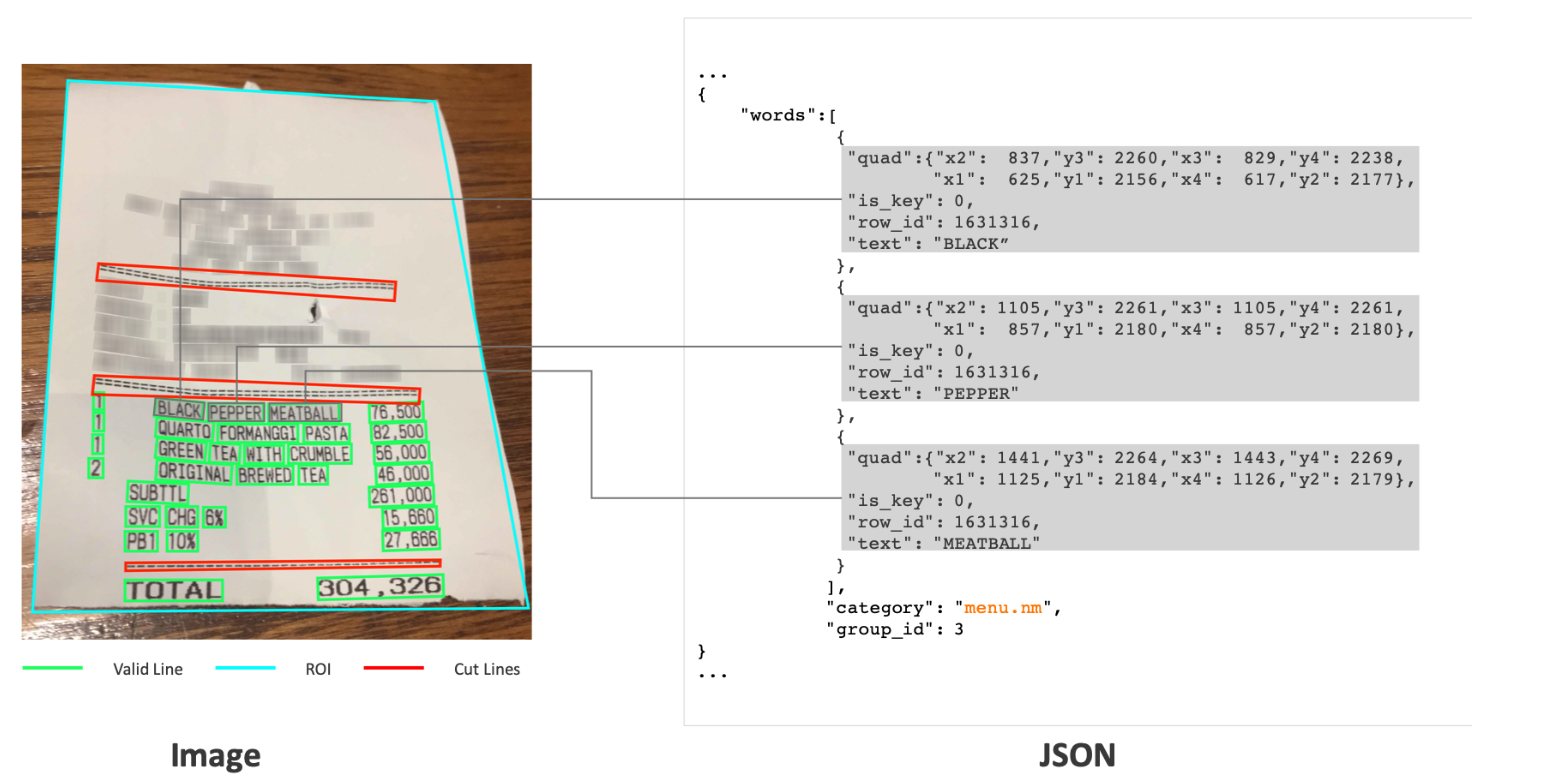

Loss function for OCR model:

$$ L = \sum_i \alpha_p L^p_i + \alpha_f L^f_i + \alpha_t L^t_i $$

where 

$ L^p_i $ is the loss for section i based on positional/layout correctness. This should be zero if the OCR model returns the exact box on the page. 

We propose that the positional loss is the intersection over union of the bounding boxes:
$$ L^p_i = IOU(\hat{b}_i, b_i) $$

where $ \hat{b}_i $ is the predicted bounding box and $ b_i $ is the ground truth bounding box.


$ L^f_i $ is the loss for section i based on font correctness. This should be zero if the OCR model returns the exact font for the section, including font family, font size and perhaps even colors.

We propose that the font loss is a delta between the predicted font and the ground truth font plus the square of the difference in font size:
$$ L^f_i = \alpha_f^f (1 - \delta(\hat{f}_i, f_i) )+ \alpha_f^s (\hat{s}_i - s_i)^2 $$

$ L^t_i $ is the loss for section i based on text correctness. This should be zero if the OCR model returns the exact text for the section.

We propose that the text loss is the edit distance between the predicted text and the ground truth text:
$$ L^t_i = ED(\hat{t}_i, t_i) $$

where $ ED $ is the edit distance function. This is equivalent to the Levenshtein distance.

$ \alpha_p, \alpha_f, \alpha_t $ are weights for each of the loss terms. These will impact the difficulty of the OCR challenge as text correctness is likely much easier than position correctness etc.

We will invert the loss to produce a reward which is to be maximized by the miner. The reward is:

$$ R = 1 / L $$

where $ L $ is the loss function defined above. This probably some epsilon to avoid division by zero.

## A Note on desired schema

As we want to score based on attributes beyond just the text we require that miners respond with the following schema:
```python
response = [
    {'index':0, 'position':[x1, x2, y1, y2], 'font_family':'Times New Roman', 'font_size':12, 'text':'Hello World!'},
    ...
]
```

We can also build in some deisrable default behaviour in case the miner is unable to do the task in the desired way:
- If response is a `str`, then we just assume that the order of sections is correct and the text is correct. 
- If response is a `List[str]`, then we assume that the order of sections is correct but the text is not. 
- If response is a `List[dict]`, then we assume that the miner has provided all the information we need.

Missing fields incur the maximum loss for that field.

# Ground Truth Data
In order to score the miner responses we need to have ground truth data with the same schema.

In [ ]:
def draw_boxes(image, response, color='red'):
    """Draws boxes around text on the image"""
    draw = ImageDraw.Draw(image)
    for item in response:
        draw.rectangle(item['position'], outline=color)
    return image

# scale data so that it matches the image size
def scale_data(data, w, h):
    scaled_data = []
    for section in data:
        entry = section.copy()
        p = section['position']
        entry['position'] = [p[0]*w, p[3]*h, p[2]*w, p[1]*h]
        scaled_data.append(entry)
    return scaled_data

In [ ]:
# Path to the image you want to extract text from
path = os.path.join(os.getcwd(), 'sample_invoice.pdf')

# Read the pdf into memory
image = pdf2image.convert_from_path(path)[0]
# convert to PIL image
image = image.convert('RGB')
# image


scaled_data = scale_data(data, *image.size)
draw_boxes(image, scaled_data, color='green')